## Import Libraries and Packages

In [ ]:
# !pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 13.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626532 sha256=008d52c6b52cec083dc2c49abd807b0a013eec2ba45b08ee450eadd6c2d61549
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from pandas.core.indexes.extension import Index

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import minmax_scale
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
import joblib
from sklearn.pipeline import Pipeline

import lightgbm as lgb
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import shap

In [2]:
pd.set_option('display.max_columns', None)

# Connecting to colab

In [3]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


## Mounting to google drive

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/cleaned_data.csv')

In [6]:
df = df.drop(['index','Unnamed: 0.1'], axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   10000 non-null  int64  
 1   uniq_id                                      10000 non-null  object 
 2   product_name                                 10000 non-null  object 
 3   manufacturer                                 10000 non-null  object 
 4   price                                        10000 non-null  float64
 5   number_available_in_stock                    10000 non-null  float64
 6   number_of_reviews                            10000 non-null  float64
 7   number_of_answered_questions                 10000 non-null  float64
 8   average_review_rating                        10000 non-null  float64
 9   category_and_sub_category                    10000 non-null  object 
 10 

# Reviews Sentiment

## Aspect Based Sentiment Analysis

- in order run the sentiment analysis on your machine, you need to install following libraries and model(en-core-web-lg)

In [10]:
# !pip install -U spacy
# !python -m spacy download en_core_web_lg
# !pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.7 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np

#### Reference

https://www.kaggle.com/code/phiitm/aspect-based-sentiment-analysis

In [12]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/df_after_clean.csv')

In [13]:
data5 = pd.DataFrame(df[['customer_reviews', 'uniq_id']])

In [14]:
data5 = data5.rename(columns = {'customer_reviews':'review_body'})

In [15]:
data5.head()

,review_body,uniq_id
0,Worth Buying For The Pictures Alone (As Ever) ...,eac7efa5dbd3d667f26eb3d3ab504464
1,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,b17540ef7e86e461d37f3ae58b7b72ac
2,**Highly Recommended!** // 5.0 // 26 May 2015 ...,348f344247b0c1a935b1223072ef9d8a
3,I love it // 5.0 // 22 July 2013 // By\n \n...,e12b92dbb8eaee78b22965d2a9bbbd9f
4,Birthday present // 5.0 // 14 April 2014 // By...,e33a9adeed5f36840ccc227db4682a36


In [16]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  9979 non-null   object
 1   uniq_id      10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [17]:
data5.shape

(10000, 2)

In [18]:
data = data5.reset_index()

In [19]:
data.head()

,index,review_body,uniq_id
0,0,Worth Buying For The Pictures Alone (As Ever) ...,eac7efa5dbd3d667f26eb3d3ab504464
1,1,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,b17540ef7e86e461d37f3ae58b7b72ac
2,2,**Highly Recommended!** // 5.0 // 26 May 2015 ...,348f344247b0c1a935b1223072ef9d8a
3,3,I love it // 5.0 // 22 July 2013 // By\n \n...,e12b92dbb8eaee78b22965d2a9bbbd9f
4,4,Birthday present // 5.0 // 14 April 2014 // By...,e33a9adeed5f36840ccc227db4682a36


In [20]:
import os
import re
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')

In [24]:
aspect_terms = []
# comp_terms = []

def get_aspect_adj(data):
    for x in tqdm(range(len(data['review_body']))):
        amod_pairs = []
        advmod_pairs = []
        # compound_pairs = []
        xcomp_pairs = []
        neg_pairs = []

        if len(str(data['review_body'][x])) != 0:
            lines = str(data['review_body'][x]).replace('*',' ').replace('-',' ').replace('so ',' ').replace('be ',' ').replace('are ',' ').replace('just ',' ').replace('get ','').replace('were ',' ').replace('When ','').replace('when ','').replace('again ',' ').replace('where ','').replace('how ',' ').replace('has ',' ').replace('Here ',' ').replace('here ',' ').replace('now ',' ').replace('see ',' ').replace('why ',' ').split('.')       
            for line in lines:
                    doc = nlp(line)
                    str1=''
                    str2=''
                    for token in doc:
                        if token.pos_ == 'NOUN':
                            for j in token.lefts:
                                # if j.dep_ == 'compound':
                                #     compound_pairs.append((j.text+' '+token.text,token.text))
                                if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                                    str1 = j.text+' '+token.text
                                    amod_pairs.append(j.text+' '+token.text)
                                    for k in j.lefts:
                                        if k.dep_ == 'advmod': 
                                            str2 = k.text+' '+j.text+' '+token.text
                                            amod_pairs.append(k.text+' '+j.text+' '+token.text)
                                    mtch = re.search(re.escape(str1),re.escape(str2))
                                    if mtch != None:
                                        amod_pairs.remove(str1)
                        if token.pos_ == 'VERB':
                            for j in token.lefts:
                                if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                                    advmod_pairs.append(j.text+' '+token.text)
                                if j.dep_ == 'neg' and j.pos_ == 'ADV':
                                    neg_pairs.append(j.text+' '+token.text)
                            for j in token.rights:
                                if j.dep_ == 'advmod'and j.pos_ == 'ADV':
                                    advmod_pairs.append(token.text+' '+j.text)
                        if token.pos_ == 'ADJ':
                            for j,h in zip(token.rights,token.lefts):
                                if j.dep_ == 'xcomp' and h.dep_ != 'neg':
                                    for k in j.lefts:
                                        if k.dep_ == 'aux':
                                            xcomp_pairs.append(token.text+' '+k.text+' '+j.text)
                                elif j.dep_ == 'xcomp' and h.dep_ == 'neg':
                                    if k.dep_ == 'aux':
                                            neg_pairs.append(h.text +' '+token.text+' '+k.text+' '+j.text)

            pairs = list(set(amod_pairs+advmod_pairs+neg_pairs+xcomp_pairs))
  
            # for i in range(len(pairs)):
            #     if len(compound_pairs)!=0:
            #         for comp in compound_pairs:
            #             mtch = re.search(re.escape(comp[1]),re.escape(pairs[i]))
            #             if mtch != None:
            #                 pairs[i] = pairs[i].replace(mtch.group(),comp[0])
            
        aspect_terms.append(pairs)
        # comp_terms.append(compound_pairs)
        
    # data['compound_nouns'] = comp_terms
    data['aspect_keywords'] = aspect_terms
   
    return data

In [25]:
data1 = get_aspect_adj(data)

100%|██████████| 10000/10000 [27:01<00:00,  6.17it/s]


In [26]:
my_df = pd.DataFrame(columns = ['row_index','aspect_adj_string','pos_score','neg_score','compound_score','neutral_score'])
my_df

,row_index,aspect_adj_string,pos_score,neg_score,compound_score,neutral_score


In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
my_df = pd.DataFrame(columns = ['row_index','aspect_adj_string','pos_score','neg_score','compound_score','neutral_score'])
global_sentiment = {}
for aspect_adj_tuple in data1.aspect_keywords.iteritems():
    row_sentiment = {}
    for text in aspect_adj_tuple[1]:
        sentiment_array = []
        polarity = analyser.polarity_scores(text)
        # print(polarity)
        # sentiment_array.append(polarity['pos'])
        # sentiment_array.append(polarity['neg'])
        # row_sentiment[text] = sentiment_array
        my_df = my_df.append({'row_index':aspect_adj_tuple[0],'aspect_adj_string':text,'pos_score':polarity['pos'],'neg_score':polarity['neg'],'compound_score':polarity['compound'],'neutral_score':polarity['neu']},ignore_index=True)
#     global_sentiment[aspect_adj_tuple[0]] = row_sentiment
    
# print(global_sentiment)

In [28]:
my_df[(my_df['compound_score']<0) & (my_df['pos_score']>0) & (my_df['neg_score']>0)]

,row_index,aspect_adj_string,pos_score,neg_score,compound_score,neutral_score
413,36,easily damage,0.429,0.571,-0.2023,0.000
556,47,hard backing,0.440,0.560,-0.0772,0.000
2790,288,bad value,0.407,0.593,-0.2732,0.000
2803,288,extremely bad value,0.358,0.508,-0.2766,0.134
3211,334,mad playing,0.360,0.640,-0.3400,0.000
...,...,...,...,...,...,...
101296,9811,brightly coloured die,0.338,0.527,-0.3400,0.135
102903,9942,frustrating to play,0.381,0.460,-0.1280,0.159
103025,9948,cut straight,0.475,0.525,-0.0516,0.000
103369,9971,loose jokes,0.465,0.535,-0.0772,0.000


In [ ]:
# my_df.to_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/sentiment_df.csv')

In [29]:
my_df['row_index'].value_counts()

4861    112
5558    100
1635     99
9209     99
4605     99
       ... 
8767      1
487       1
3991      1
8762      1
1353      1
Name: row_index, Length: 8685, dtype: int64

In [30]:
my_df.shape

(103606, 6)

In [31]:
my_df.head(20)

,row_index,aspect_adj_string,pos_score,neg_score,compound_score,neutral_score
0,0,old ones,0.000,0.0,0.0000,1.000
1,0,previous year,0.000,0.0,0.0000,1.000
2,0,still got,0.000,0.0,0.0000,1.000
3,0,definitely buy,0.730,0.0,0.4019,0.270
4,0,new catalogue,0.000,0.0,0.0000,1.000
5,0,Extremely useful insight,0.615,0.0,0.4927,0.385
6,0,same products,0.000,0.0,0.0000,1.000
7,0,Great catalogue,0.804,0.0,0.6249,0.196
8,0,arrived quickly,0.000,0.0,0.0000,1.000
9,0,even included,0.000,0.0,0.0000,1.000


In [32]:
final_df = my_df[((my_df['compound_score']>0.1) | (my_df['compound_score']< -0.1))]

In [33]:
final_df[(final_df['compound_score']<0) & (final_df['pos_score']> final_df['neg_score'])]


,row_index,aspect_adj_string,pos_score,neg_score,compound_score,neutral_score


In [34]:
final_df['final_sentiment'] = ['pos' if i>0 else 'neg' for i in final_df['compound_score']]

In [35]:
final_df.head(50)

,row_index,aspect_adj_string,pos_score,neg_score,compound_score,neutral_score,final_sentiment
3,0,definitely buy,0.730,0.000,0.4019,0.270,pos
5,0,Extremely useful insight,0.615,0.000,0.4927,0.385,pos
7,0,Great catalogue,0.804,0.000,0.6249,0.196,pos
11,0,well produced,0.677,0.000,0.2732,0.323,pos
14,0,great book,0.804,0.000,0.6249,0.196,pos
16,0,useful insight,0.744,0.000,0.4404,0.256,pos
18,0,Amazing detail,0.792,0.000,0.5859,0.208,pos
20,0,fabulous photography,0.773,0.000,0.5267,0.227,pos
21,0,good buy,0.744,0.000,0.4404,0.256,pos
22,0,perfect condition,0.787,0.000,0.5719,0.213,pos


In [36]:
final_df['row_index'].value_counts()

9654    49
1125    44
9639    43
9209    42
4861    40
        ..
6501     1
3963     1
6502     1
615      1
6414     1
Name: row_index, Length: 7974, dtype: int64

In [37]:
final_df.shape

(46965, 7)

In [ ]:
# final_df.to_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/sentiment_final_df.csv')

## aspect opinion extraction

- After implementing this method, I realized it won't be useful for what I'm looking for

#### Reference

https://www.kaggle.com/code/anuragghosh/aspect-opinion-extraction-and-modelling

In [ ]:
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/cleaned_data.csv')

In [ ]:
data5 = pd.DataFrame(df[['customer_reviews']])

In [ ]:
data5 = data5.rename(columns = {'customer_reviews':'review_body'})

In [ ]:
data = data5.sample(frac = 0.1, random_state = 42)

In [ ]:
data.dropna(inplace = True)

In [ ]:
data = data.reset_index()

In [ ]:
data = data.drop(columns = ['index'])

In [ ]:
data

,review_body
0,Perfect // 5.0 // 25 Nov. 2015 // By\n \n ...
1,He is now living with three little knitted pig...
2,Five Stars // 5.0 // 25 Oct. 2015 // By\n \...
3,Lovely classroom resource // 4.0 // 22 Nov. 20...
4,Absolutely perfect!! // 5.0 // 14 Dec. 2015 //...
...,...
993,Five Stars // 5.0 // 4 Nov. 2015 // By\n \n...
994,Great Draw // 5.0 // 23 Feb. 2011 // By\n \...
995,Very pleased with how it all looked On // 5.0 ...
996,Realistic tattoo sleeves - very well printed d...


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def tokenize(sentence):
    sentence = re.sub(r"(?:\@|https?\://)\S+|\n+", "", sentence.lower())
    return sentence

In [ ]:
result = [tokenize(x) for x in data['review_body'].iloc[:]]

In [ ]:
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_lg")
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def find_sentiment(doc):
    # find roots of all entities in the text
    ner_heads = {ent.root.idx: ent for ent in doc.ents}
    rule3_pairs = []
    for token in doc:
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children:
            if(child.dep_ == "nsubj" and not child.is_stop): # nsubj is nominal subject
                if child.idx in ner_heads:
                    A = ner_heads[child.idx].text
                else:
                    A = child.text
            if(child.dep_ == "acomp" and not child.is_stop): # acomp is adjectival complement
                M = child.text
            if(child.dep_ == "aux" and child.tag_ == "MD"): # MD is modal auxiliary
                neg_prefix = "not"
                add_neg_pfx = True
            if(child.dep_ == "neg"): # neg is negation
                neg_prefix = child.text
                add_neg_pfx = True
        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M
        if(A != "999999" and M != "999999"):
            rule3_pairs.append((A, M, sid.polarity_scores(M)['compound']))
    return rule3_pairs

In [ ]:
print(find_sentiment(nlp("Food was good but customer service was bad. The ambience was great although")))

[('Food', 'good', 0.4404), ('service', 'bad', -0.5423), ('ambience', 'great', 0.6249)]


In [ ]:
aspect_opinion = [find_sentiment(nlp(x)) for x in result]

In [ ]:
aspect_opinion[:20]

[[],
 [('delivery', 'prompt', 0.0)],
 [],
 [('bodies', 'solid', 0.1531)],
 [],
 [],
 [('tube', 'robust', 0.34),
  ('thing', 'bigger', 0.0),
  ('game', 'simple', 0.0),
  ('game', 'cheap', 0.0),
  ('kids', 'uninterested', 0.0),
  ('game', 'simple', 0.0)],
 [('seller', 'helpful', 0.4215), ('cards', 'bigger', 0.0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [('daughter', 'mad', -0.4939),
  ('work', 'good', 0.4404),
  ('deatil', 'great', 0.6249)],
 [('detail', 'outstanding', 0.6124), ('figure', 'loyal', 0.4767)],
 [('packaging', 'adequate', 0.2263)],
 [],
 [],
 [('size', 'awesome', 0.6249), ('son', 'happy', 0.5719)]]

In [ ]:
for i in range(7,8):
  print(data['review_body'][i])

Lge size playing cars + game board // 5.0 // 24 July 2012 // By
    
    silviesurfer
  
 on 24 July 2012 // Ordered this game board and playing cards for elderly residents in a retirement village, and have to say that the seller was most helpful and informative, and the price was brilliant, excellent value, and very prompt delivery, at a very resonable cost.  Pleased to say that the game is enjoyed by all.  Very many thanks. Regards, S. Yearsley | Great cowd pleaser! // 5.0 // 27 July 2012 // By
    
    Mr Quiz
  
 on 27 July 2012 // Just want to say a massive thanks, the product is great quality and the fact it can be signwriten to your own specification makes it all the more appealing, Great fun and great feedback from the audience at our local quiz night.Good value all round purchase!Cheers | Brilliant // 5.0 // 3 Nov. 2015 // By
    
    suzieq
  
 on 3 Nov. 2015 // Brilliant, The only thing missing was a voice over with Bruce Forsyths voice,, saying "good game"Haha. Well worth v

In [ ]:
print(find_sentiment(nlp("Really pleased with product. Very good customer service. Would recommend highly ")))

[]


# Market Basket

## Items bought together

### Small subset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/df_without_name_matching.csv')

In [ ]:
sample = df.sample(frac = 0.2, random_state = 42)

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 6252 to 6929
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   2000 non-null   int64  
 1   Unnamed: 0.1                                 2000 non-null   int64  
 2   uniq_id                                      2000 non-null   object 
 3   product_name                                 2000 non-null   object 
 4   manufacturer                                 2000 non-null   object 
 5   price                                        2000 non-null   float64
 6   number_available_in_stock                    2000 non-null   float64
 7   number_of_reviews                            2000 non-null   float64
 8   number_of_answered_questions                 2000 non-null   float64
 9   average_review_rating                        2000 non-null   float64
 1

In [ ]:
sample = sample.replace('None',np.nan, regex = True)

''https://www.kaggle.com/code/sajidcse/market-basket-analysis#Apriori-Algorithm''

In [ ]:
basket_sample = pd.DataFrame(sample[['uniq_id', '0together', '1together', '2together', '3together'\
                  , '4together', '5together', '6together', '7together', '8together', '9together'\
                  , '10together', '11together']])

In [ ]:
basket_sample = basket_sample.replace('nan',np.nan, regex = True)

In [ ]:
basket_sample.shape

(2000, 13)

In [ ]:
trans=[]
for i in range(0,2000):
    trans.append([str(basket_sample.values[i,j]) for j in range(0,13)])

trans=np.array(trans)

print(trans.shape)

(2000, 13)


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
t=TransactionEncoder()
data=t.fit_transform(trans)
data=pd.DataFrame(data,columns=t.columns_,dtype=int)

data.shape

(2000, 9530)

In [ ]:
data.drop('nan',axis=1,inplace=True)

In [ ]:
print(data.shape)

'nan' in data.columns

(2000, 9529)


False

[Text(0, 0, 'Ravensburger'),
 Text(0, 0, 'Amscan International'),
 Text(0, 0, 'Scalextric'),
 Text(0, 0, 'Birthday Tropical Assorted Qualatex Balloons'),
 Text(0, 0, 'MyTinyWorld'),
 Text(0, 0, 'Transformers'),
 Text(0, 0, 'BLACK SILVER HAPPY BIRTHDAY BANNER'),
 Text(0, 0, 'SmartDealsPro'),
 Text(0, 0, 'Tommee Tippee Sangenic Compatible'),
 Text(0, 0, 'Personalised'),
 Text(0, 0, 'Silver Hearts Holographic'),
 Text(0, 0, 'Trading Card Sleeves Protectors'),
 Text(0, 0, 'Dungeons Dragons Players Handbook Rulebooks'),
 Text(0, 0, 'Revell 39604 Contacta Professional'),
 Text(0, 0, 'Yu Gi Oh Premium Gold Booster Pack'),
 Text(0, 0, 'The Creativity'),
 Text(0, 0, 'Polyhedral'),
 Text(0, 0, 'k2 accessories'),
 Text(0, 0, 'Waddingtons'),
 Text(0, 0, 'Glitz Black Birthday Bunting Banner')]

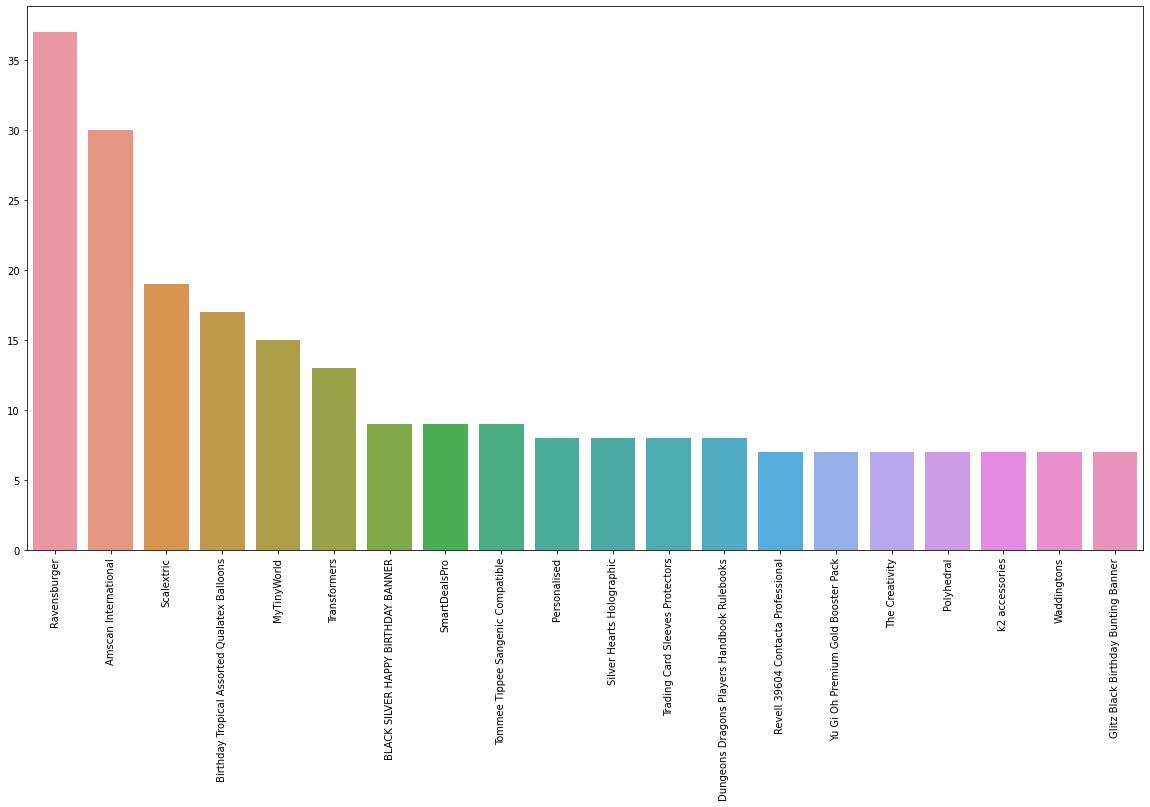

In [ ]:
##Lets consider the top 20 items purchased freequently
r=data.sum(axis=0).sort_values(ascending=False)[:20]

plt.figure(figsize=(20,10))
s=sns.barplot(x=r.index,y=r.values)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(0.0, 100.0, 0.0, 100.0)

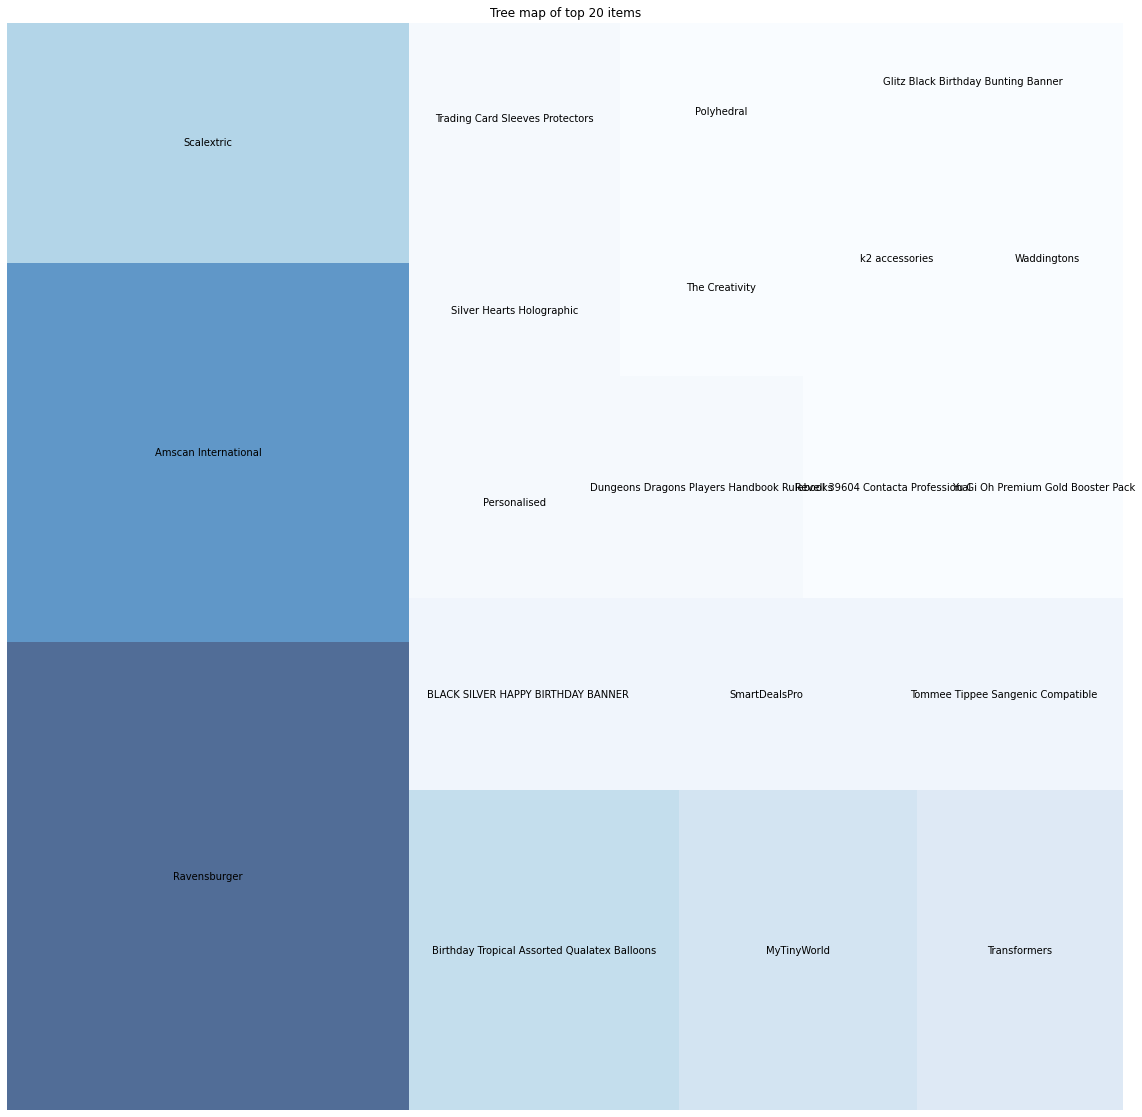

In [ ]:
import matplotlib
import squarify
my_values=r.values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]


#treemap of top 20 frequent items
plt.figure(figsize=(20, 20))
squarify.plot(sizes=r.values, label=r.index, alpha=.7,color=colors)
plt.title("Tree map of top 20 items")
plt.axis('off')

In [ ]:
!pip install mlxtend --upgrade

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

**- Chose one of these two references(First or Second)**
- for the graph bellow, I used second reference

#### First reference

'https://www.kaggle.com/code/sajidcse/market-basket-analysis#Apriori-Algorithm'

In [ ]:
# freq_items=apriori(data,min_support=0.001,use_colnames=True)

In [ ]:
# freq_items

In [ ]:
# res=association_rules(freq_items,metric="lift",min_threshold=1)

In [ ]:
# res

In [ ]:
# frequent_itemsets = apriori(data, min_support = 0.001, use_colnames=True)
# frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# frequent_itemsets

In [ ]:
# frequent_itemsets[ (frequent_itemsets['length'] == 2) &
#                    (frequent_itemsets['support'] >= 0.001) ]

In [ ]:
# import time
# l=[0.01,0.02,0.03,0.04,0.05, 0.001]
# t=[]
# for i in l:
#     t1=time.time()
#     apriori(data,min_support=i,use_colnames=True)
#     t2=time.time()
#     t.append((t2-t1)*1000)

#### Second reference

'https://www.kaggle.com/code/akashdeepkuila/market-basket-analysis'

In [ ]:
frequentItems = apriori(data, min_support = 0.002, use_colnames=True)
frequentItems

,support,itemsets
0,0.0025,(15pcs Miniature Porcelain Plate Colorful Floral)
1,0.0030,(Alison Gardiner Traditional)
2,0.0025,(Amscan 674473 Hollywood Swirls Decorations)
3,0.0150,(Amscan International)
4,0.0020,(Anniversary)
...,...,...
134,0.0020,"(Polyhedral, Q Workshop Polyhedral)"
135,0.0020,"(Rory Story Cubes Animalia Dice, The Creativity)"
136,0.0020,"(The Creativity, Rorys Story Cubes Intergalactic)"
137,0.0020,"(Hollywood themed party Prom confetti, Carpet ..."


In [ ]:
rules = association_rules(frequentItems, metric="lift", min_threshold=1)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Carpet Hollywood Scene Setter Runner,Amscan 674473 Hollywood Swirls Decorations,0.0020,0.0025,0.002,1.000000,400.000000,0.001995,inf
1,Amscan 674473 Hollywood Swirls Decorations,Carpet Hollywood Scene Setter Runner,0.0025,0.0020,0.002,0.800000,400.000000,0.001995,4.990000
2,Hollywood themed party Prom confetti,Amscan 674473 Hollywood Swirls Decorations,0.0020,0.0025,0.002,1.000000,400.000000,0.001995,inf
3,Amscan 674473 Hollywood Swirls Decorations,Hollywood themed party Prom confetti,0.0025,0.0020,0.002,0.800000,400.000000,0.001995,4.990000
4,BIRTHDAY GIRL PINK PARTY BALLOONS,Birthday Tropical Assorted Qualatex Balloons,0.0020,0.0085,0.002,1.000000,117.647059,0.001983,inf
5,Birthday Tropical Assorted Qualatex Balloons,BIRTHDAY GIRL PINK PARTY BALLOONS,0.0085,0.0020,0.002,0.235294,117.647059,0.001983,1.305077
6,BLACK SILVER HAPPY BIRTHDAY BANNER,Glitz Black Birthday Bunting Banner,0.0045,0.0035,0.002,0.444444,126.984127,0.001984,1.793700
7,Glitz Black Birthday Bunting Banner,BLACK SILVER HAPPY BIRTHDAY BANNER,0.0035,0.0045,0.002,0.571429,126.984127,0.001984,2.322833
8,BLACK SILVER HAPPY BIRTHDAY BANNER,Glitz Black Silver Birthday Balloons,0.0045,0.0030,0.002,0.444444,148.148148,0.001986,1.794600
9,Glitz Black Silver Birthday Balloons,BLACK SILVER HAPPY BIRTHDAY BANNER,0.0030,0.0045,0.002,0.666667,148.148148,0.001986,2.986500


In [ ]:
!pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 210 kB/s 
     |████████████████████████████████| 2.0 MB 67.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [ ]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.2 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [ ]:
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
network_A = list(rules["antecedents"].unique())
network_B = list(rules["consequents"].unique())
node_list = list(set(network_A + network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules.iterrows():
    G.add_edges_from([(j["antecedents"], j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers', hoverinfo='text',
    marker=dict(showscale=True, colorscale='Burg', reversescale=True, color=[], size=15,
    colorbar=dict(thickness=10, title='Node Connections', xanchor='left', titleside='right')))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +'<br>No of Connections: {}'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace], 
    layout=go.Layout(title='Item Connections Network', titlefont=dict(size=20),
    plot_bgcolor='white', showlegend=False, margin=dict(b=0,l=0,r=0,t=50),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

### Entire Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/df_without_name_matching.csv')

In [ ]:
basket_sample = pd.DataFrame(df[['product_name', '0together', '1together', '2together', '3together'\
                  , '4together', '5together', '6together', '7together', '8together', '9together'\
                  , '10together', '11together']])

In [ ]:
basket_sample = basket_sample.replace('nan',np.nan, regex = True)

In [ ]:
basket_sample.shape

(10000, 13)

In [ ]:
trans=[]
for i in range(0,10000):
    trans.append([str(basket_sample.values[i,j]) for j in range(0,13)])

trans=np.array(trans)

print(trans.shape)

(10000, 13)


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
t=TransactionEncoder()
data=t.fit_transform(trans)
data=pd.DataFrame(data,columns=t.columns_,dtype=int)

data.shape

(10000, 36981)

In [ ]:
data.drop('nan',axis=1,inplace=True)

In [ ]:
print(data.shape)

'nan' in data.columns

(10000, 36980)


False

[Text(0, 0, 'Ravensburger'),
 Text(0, 0, 'Amscan International'),
 Text(0, 0, 'Scalextric'),
 Text(0, 0, 'Transformers'),
 Text(0, 0, 'MyTinyWorld'),
 Text(0, 0, 'Trading Card Sleeves Protectors'),
 Text(0, 0, 'Dungeons Dragons Players Handbook Rulebooks'),
 Text(0, 0, 'Birthday Tropical Assorted Qualatex Balloons'),
 Text(0, 0, 'Revell 39604 Contacta Professional'),
 Text(0, 0, 'Tommee Tippee Sangenic Compatible'),
 Text(0, 0, 'Dungeon Masters Dungeons Dragons Rulebooks'),
 Text(0, 0, 'Yu Gi Oh Legendary Collection'),
 Text(0, 0, 'Johnsons Extra Sensitive Baby wipes'),
 Text(0, 0, 'Yu Gi Oh Premium Gold Booster Pack'),
 Text(0, 0, 'k2 accessories'),
 Text(0, 0, 'OnlineRetail EU S %C3%A0 r l OnlineRetail co uk Printable'),
 Text(0, 0, 'Monster Manual Dungeons Rulebook Rulebooks'),
 Text(0, 0, 'Inflatable'),
 Text(0, 0, 'Hanging Glitz Prism Birthday Decorations'),
 Text(0, 0, 'Despicable')]

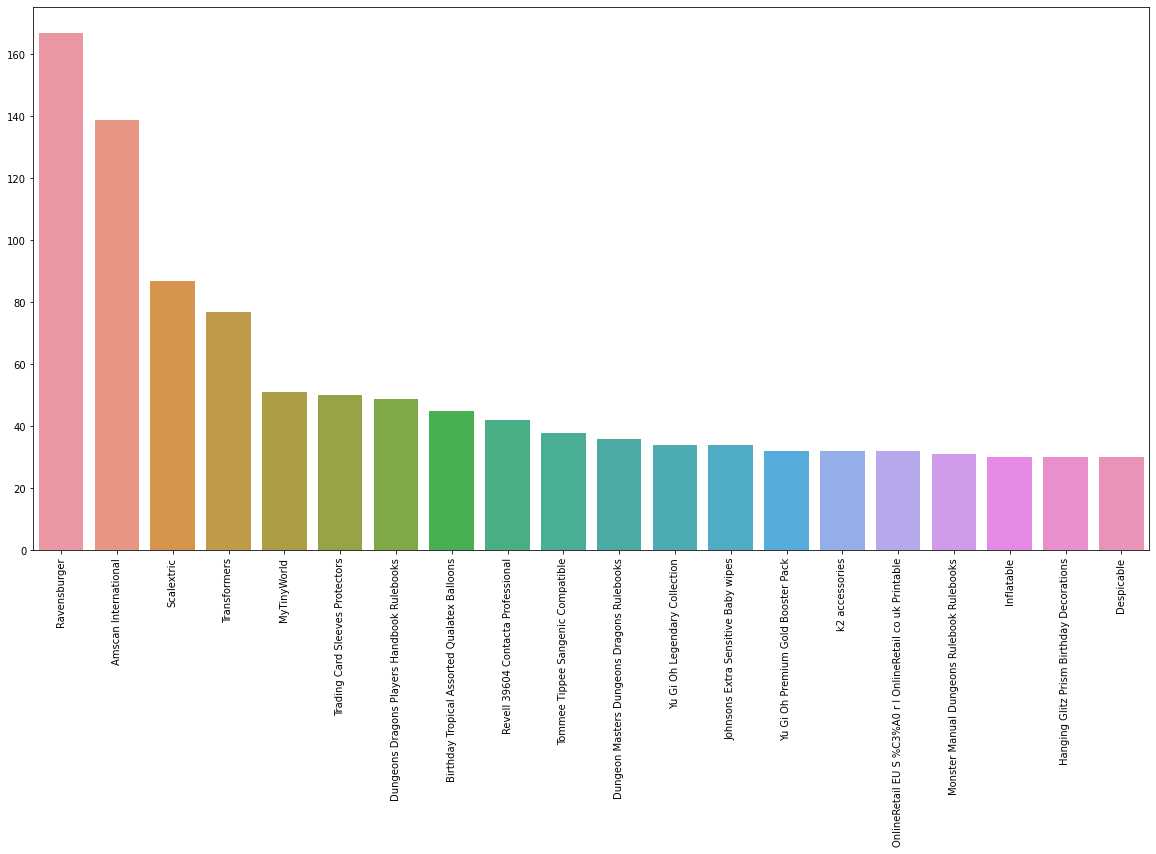

In [ ]:
##Lets consider the top 20 items purchased freequently
r=data.sum(axis=0).sort_values(ascending=False)[:20]

plt.figure(figsize=(20,10))
s=sns.barplot(x=r.index,y=r.values)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(0.0, 100.0, 0.0, 100.0)

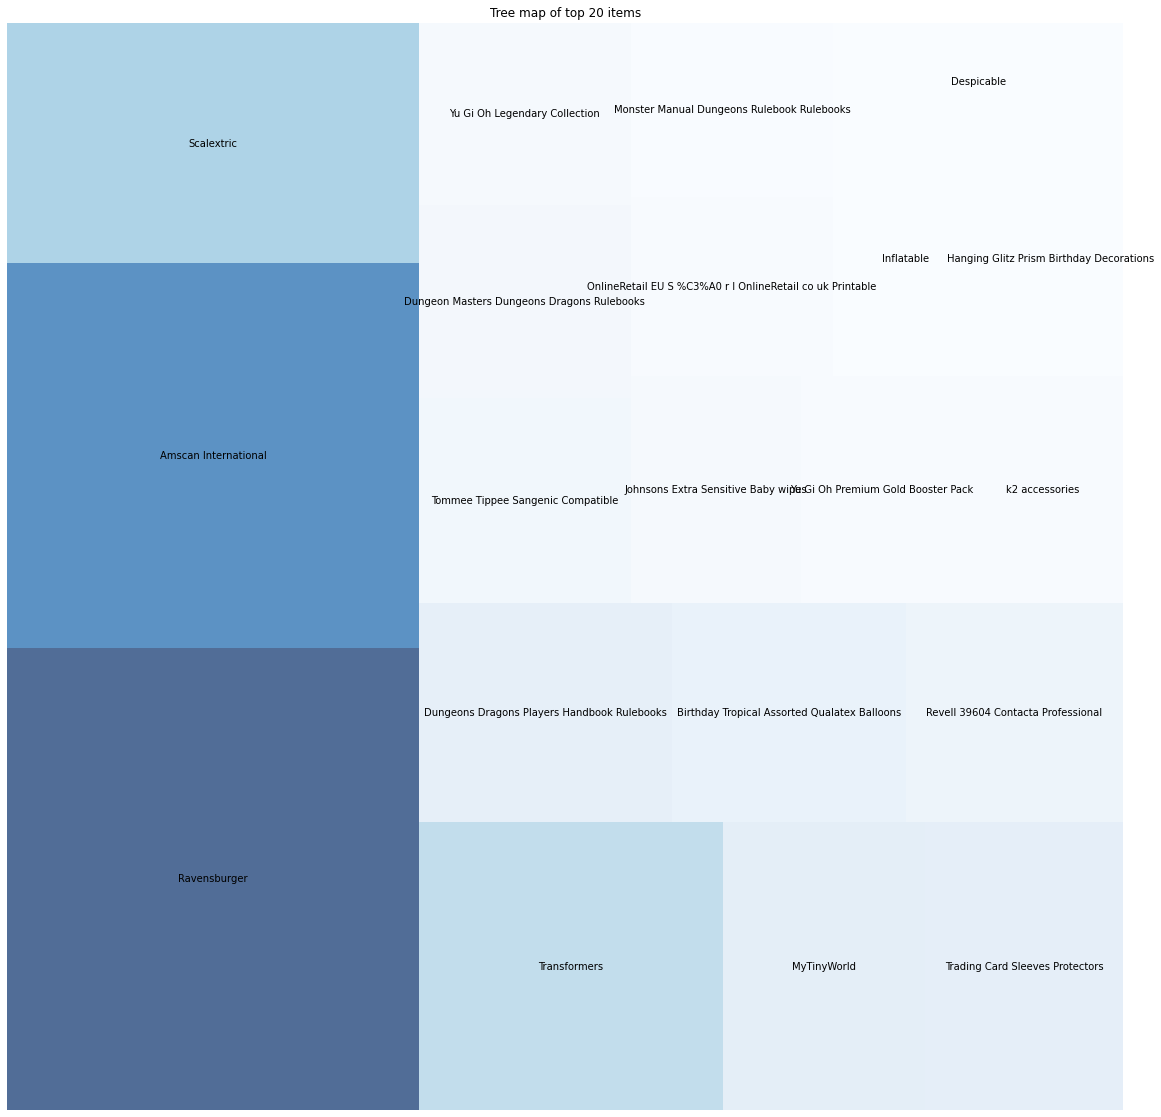

In [ ]:
import matplotlib
import squarify
my_values=r.values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]


#treemap of top 20 frequent items
plt.figure(figsize=(20, 20))
squarify.plot(sizes=r.values, label=r.index, alpha=.7,color=colors)
plt.title("Tree map of top 20 items")
plt.axis('off')

In [ ]:
# !pip install mlxtend --upgrade

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

**- Chose one of these two references(First or Second)**

#### First reference

'https://www.kaggle.com/code/sajidcse/market-basket-analysis#Apriori-Algorithm'

In [ ]:
# freq_items=apriori(data,min_support=0.001,use_colnames=True)

In [ ]:
# freq_items

In [ ]:
# res=association_rules(freq_items,metric="lift",min_threshold=1)

In [ ]:
# res

In [ ]:
# frequent_itemsets = apriori(data, min_support = 0.001, use_colnames=True)
# frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# frequent_itemsets

In [ ]:
# frequent_itemsets[ (frequent_itemsets['length'] == 2) &
#                    (frequent_itemsets['support'] >= 0.001) ]

In [ ]:
# import time
# l=[0.01,0.02,0.03,0.04,0.05, 0.001]
# t=[]
# for i in l:
#     t1=time.time()
#     apriori(data,min_support=i,use_colnames=True)
#     t2=time.time()
#     t.append((t2-t1)*1000)

#### Second reference

'https://www.kaggle.com/code/akashdeepkuila/market-basket-analysis'

In [ ]:
frequentItems = apriori(data, min_support = 0.001, use_colnames=True)
frequentItems

,support,itemsets
0,0.0017,(12pcs 1 2 inch Scenery Landscape)
1,0.0011,(12th Scale Dolls House Roofing)
2,0.0011,(15ml Body Adhesive brush applicator)
3,0.0022,(15pcs Miniature Porcelain Plate Colorful Floral)
4,0.0011,(Accessories)
...,...,...
300,0.0010,"(Dungeon Masters Dungeons Dragons Rulebooks, D..."
301,0.0010,"(Dungeons Dragons Players Handbook Rulebooks, ..."
302,0.0010,"(Hanging Glitz Prism Birthday Decorations, Gli..."
303,0.0013,"(Dungeon Masters Dungeons Dragons Rulebooks, D..."


In [ ]:
rules = association_rules(frequentItems, metric="lift")
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,15ml Body Adhesive brush applicator,Girls 10ml Glitter Tattoo Glue,0.0011,0.0027,0.0011,1.000000,370.370370,0.001097,inf
1,Girls 10ml Glitter Tattoo Glue,15ml Body Adhesive brush applicator,0.0027,0.0011,0.0011,0.407407,370.370370,0.001097,1.685644
2,Dollhouse Miniature Assorted Chocolate Strawberry,15pcs Miniature Porcelain Plate Colorful Floral,0.0012,0.0022,0.0011,0.916667,416.666667,0.001097,11.973600
3,15pcs Miniature Porcelain Plate Colorful Floral,Dollhouse Miniature Assorted Chocolate Strawberry,0.0022,0.0012,0.0011,0.500000,416.666667,0.001097,1.997600
4,Silver Hearts Holographic,Birthday Tropical Assorted Qualatex Balloons,0.0024,0.0045,0.0010,0.416667,92.592593,0.000989,1.706571
5,Birthday Tropical Assorted Qualatex Balloons,Silver Hearts Holographic,0.0045,0.0024,0.0010,0.222222,92.592593,0.000989,1.282629
6,Chessex Dice Polyhedral,Polyhedral,0.0011,0.0020,0.0010,0.909091,454.545455,0.000998,10.978000
7,Polyhedral,Chessex Dice Polyhedral,0.0020,0.0011,0.0010,0.500000,454.545455,0.000998,1.997800
8,Clementoni,Ravensburger,0.0015,0.0167,0.0012,0.800000,47.904192,0.001175,4.916500
9,Ravensburger,Clementoni,0.0167,0.0015,0.0012,0.071856,47.904192,0.001175,1.075803


In [ ]:
!pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 210 kB/s 
     |████████████████████████████████| 2.0 MB 67.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [ ]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.2 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [ ]:
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
network_A = list(rules["antecedents"].unique())
network_B = list(rules["consequents"].unique())
node_list = list(set(network_A + network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules.iterrows():
    G.add_edges_from([(j["antecedents"], j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers', hoverinfo='text',
    marker=dict(showscale=True, colorscale='Burg', reversescale=True, color=[], size=15,
    colorbar=dict(thickness=10, title='Node Connections', xanchor='left', titleside='right')))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +'<br>No of Connections: {}'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace], 
    layout=go.Layout(title='Item Connections Network', titlefont=dict(size=20),
    plot_bgcolor='white', showlegend=False, margin=dict(b=0,l=0,r=0,t=50),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

## Items bought after

### Entire Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WALMART/CAPSTONE project/Data/Temp data/df_without_name_matching.csv')

In [ ]:
basket_sample = pd.DataFrame(df[['product_name', '0after', '1after', '2after', '3after']])

In [ ]:
basket_sample = basket_sample.replace('nan',np.nan, regex = True)

In [ ]:
basket_sample.shape

(10000, 5)

In [ ]:
trans=[]
for i in range(0,10000):
    trans.append([str(basket_sample.values[i,j]) for j in range(0,5)])

trans=np.array(trans)

print(trans.shape)

(10000, 5)


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
t=TransactionEncoder()
data=t.fit_transform(trans)
data=pd.DataFrame(data,columns=t.columns_,dtype=int)

data.shape

(10000, 23264)

In [ ]:
data.drop('nan',axis=1,inplace=True)

In [ ]:
print(data.shape)

'nan' in data.columns

(10000, 23263)


False

[Text(0, 0, 'Ravensburger'),
 Text(0, 0, 'Amscan International'),
 Text(0, 0, 'Revell 39604 Contacta Professional'),
 Text(0, 0, 'Scalextric'),
 Text(0, 0, 'Transformers'),
 Text(0, 0, 'Dungeons Dragons Players Handbook Rulebooks'),
 Text(0, 0, 'Asmodee ASMDOBB01EN'),
 Text(0, 0, 'Cards Against Humanity UK edition'),
 Text(0, 0, 'Fiesta T 2343 Monkey Puppet'),
 Text(0, 0, 'Hornby R8222 Gauge Track Extension'),
 Text(0, 0, 'MyTinyWorld'),
 Text(0, 0, 'Hama Beads 10 000 Bucket'),
 Text(0, 0, 'Magic Gathering Origins Deck Builders'),
 Text(0, 0, 'Silver Hearts Holographic'),
 Text(0, 0, 'Inflatable'),
 Text(0, 0, 'Yu Gi Oh Games Yugis Legendary Holiday'),
 Text(0, 0, 'Trading Card Sleeves Protectors'),
 Text(0, 0, 'BRIO Rail Magnetic Bell Signal'),
 Text(0, 0, 'G%C3%BCnther 1159 Childrens Rainbow Colours'),
 Text(0, 0, 'Girls 10ml Glitter Tattoo Glue')]

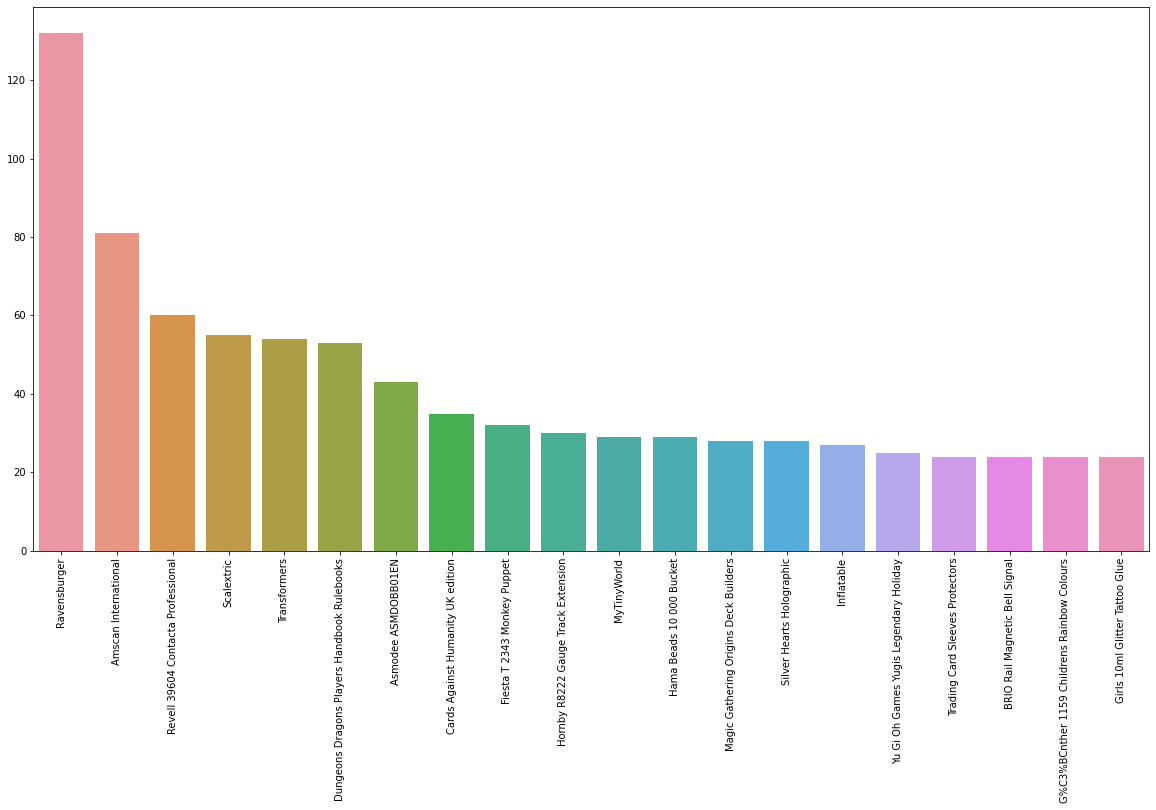

In [ ]:
##Lets consider the top 20 items purchased freequently
r=data.sum(axis=0).sort_values(ascending=False)[:20]

plt.figure(figsize=(20,10))
s=sns.barplot(x=r.index,y=r.values)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(0.0, 100.0, 0.0, 100.0)

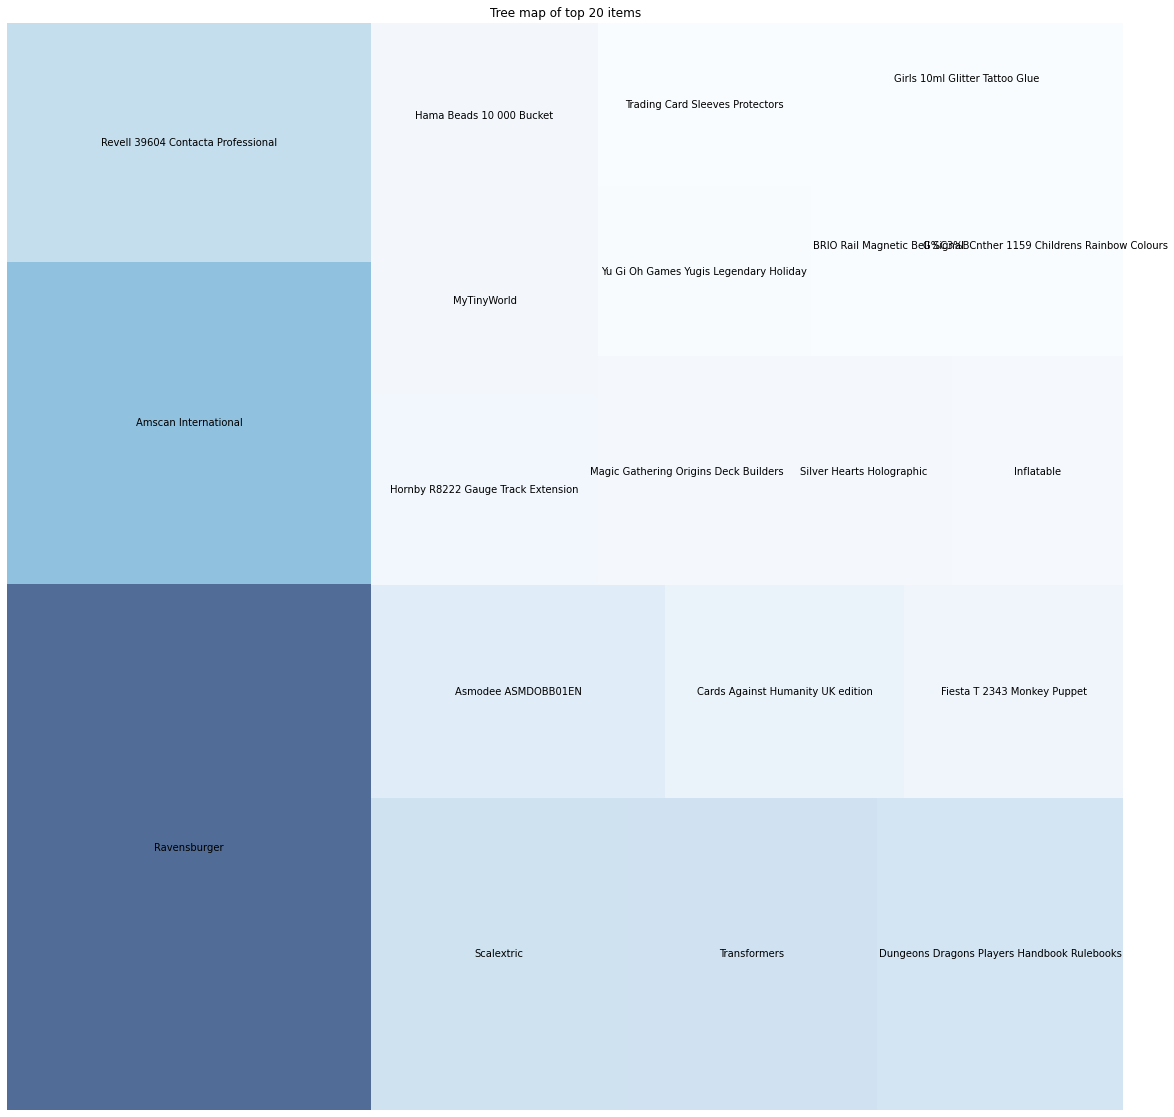

In [ ]:
import matplotlib
import squarify
my_values=r.values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]


#treemap of top 20 frequent items
plt.figure(figsize=(20, 20))
squarify.plot(sizes=r.values, label=r.index, alpha=.7,color=colors)
plt.title("Tree map of top 20 items")
plt.axis('off')

In [ ]:
# !pip install mlxtend --upgrade

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

**- Chose one of these two references(First or Second)**

#### First reference

'https://www.kaggle.com/code/sajidcse/market-basket-analysis#Apriori-Algorithm'

In [ ]:
# freq_items=apriori(data,min_support=0.001,use_colnames=True)

In [ ]:
# freq_items

In [ ]:
# res=association_rules(freq_items,metric="lift",min_threshold=1)

In [ ]:
# res

In [ ]:
# frequent_itemsets = apriori(data, min_support = 0.001, use_colnames=True)
# frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# frequent_itemsets

In [ ]:
# frequent_itemsets[ (frequent_itemsets['length'] == 2) &
#                    (frequent_itemsets['support'] >= 0.001) ]

In [ ]:
# import time
# l=[0.01,0.02,0.03,0.04,0.05, 0.001]
# t=[]
# for i in l:
#     t1=time.time()
#     apriori(data,min_support=i,use_colnames=True)
#     t2=time.time()
#     t.append((t2-t1)*1000)

#### Second reference

'https://www.kaggle.com/code/akashdeepkuila/market-basket-analysis'

In [ ]:
'''This cell will not work unless increase min_support to a number at least around 0.001'''

frequentItems = apriori(data, min_support = 0.00004, use_colnames=True)
frequentItems

In [ ]:
rules = association_rules(frequentItems, metric="lift")
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Woodeyland,Crafted Cherry Wooden Chess Draughts,0.0016,0.0023,0.0013,0.812500,353.260870,0.001296,5.321067
1,Crafted Cherry Wooden Chess Draughts,Woodeyland,0.0023,0.0016,0.0013,0.565217,353.260870,0.001296,2.296320
2,Dungeon Masters Dungeons Dragons Rulebooks,Dungeons Dragons Players Handbook Rulebooks,0.0015,0.0053,0.0015,1.000000,188.679245,0.001492,inf
3,Dungeons Dragons Players Handbook Rulebooks,Dungeon Masters Dungeons Dragons Rulebooks,0.0053,0.0015,0.0015,0.283019,188.679245,0.001492,1.392645
4,Dungeons Dragons Players Handbook Rulebooks,Dungeons Dragons Starter Boxed Game,0.0053,0.0012,0.0010,0.188679,157.232704,0.000994,1.231079
5,Dungeons Dragons Starter Boxed Game,Dungeons Dragons Players Handbook Rulebooks,0.0012,0.0053,0.0010,0.833333,157.232704,0.000994,5.968200
6,Dungeons Dragons Players Handbook Rulebooks,Monster Manual Dungeons Rulebook Rulebooks,0.0053,0.0019,0.0016,0.301887,158.887786,0.001590,1.429711
7,Monster Manual Dungeons Rulebook Rulebooks,Dungeons Dragons Players Handbook Rulebooks,0.0019,0.0053,0.0016,0.842105,158.887786,0.001590,6.299767
8,Q Workshop Polyhedral,Dungeons Dragons Players Handbook Rulebooks,0.0018,0.0053,0.0013,0.722222,136.268344,0.001290,3.580920
9,Dungeons Dragons Players Handbook Rulebooks,Q Workshop Polyhedral,0.0053,0.0018,0.0013,0.245283,136.268344,0.001290,1.322615


In [ ]:
!pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 210 kB/s 
     |████████████████████████████████| 2.0 MB 67.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [ ]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.2 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [ ]:
'''This graph is generated with min_support around 0.001'''

import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
network_A = list(rules["antecedents"].unique())
network_B = list(rules["consequents"].unique())
node_list = list(set(network_A + network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules.iterrows():
    G.add_edges_from([(j["antecedents"], j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers', hoverinfo='text',
    marker=dict(showscale=True, colorscale='Burg', reversescale=True, color=[], size=15,
    colorbar=dict(thickness=10, title='Node Connections', xanchor='left', titleside='right')))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +'<br>No of Connections: {}'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace], 
    layout=go.Layout(title='Item Connections Network', titlefont=dict(size=20),
    plot_bgcolor='white', showlegend=False, margin=dict(b=0,l=0,r=0,t=50),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

# From here, it's just for testing